In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

#tf.set_random_seed(219)
#np.random.seed(219)

sess_config = tf.ConfigProto()
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/jk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Training Flags (hyperparameter configuration)
train_dir = 'train/dcgan/'
max_epochs = 10
save_epochs = 10
summary_steps = 2000
print_steps = 500
batch_size = 64
learning_rate_D = 0.0002
learning_rate_G = 0.001
k = 1 # the number of step of learning D before learning G
num_samples = 16

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), _ = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data
train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

In [4]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<BatchDataset shapes: (?, 28, 28), types: tf.float64>


In [5]:
class DCGAN(object):
    """Deep Convolutional Generative Adversarial Networks
    implementation based on http://arxiv.org/abs/1511.06434

    "Unsupervised Representation Learning with
    Deep Convolutional Generative Adversarial Networks"
    Alec Radford, Luke Metz and Soumith Chintala
    """

    def __init__(self, mode, train_dataset, test_dataset=None):
        """Basic setup.

        Args:
          mode (`string`): "train" or "generate".
          train_dataset (`tf.data.Dataset`): train_dataset.
          test_dataset (`tf.data.Dataset`): test_dataset.
        """
        assert mode in ["train", "generate"]
        self.mode = mode

        # hyper-parameters for model
        self.x_dim = 28
        self.z_dim = 100
        self.batch_size = batch_size
        self.num_samples = num_samples
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

        # Global step Tensor.
        self.global_step = None

        print('The mode is %s.' % self.mode)
        print('complete initializing model.')


    def build_random_z_inputs(self):
        """Build a vector random_z in latent space.

        Returns:
          self.random_z (`2-rank Tensor` with [batch_size, z_dim]):
              latent vector which size is generally 100 dim.
          self.sample_random_z (`2-rank Tensor` with [num_samples, z_dim]):
              latent vector which size is generally 100 dim.
        """
        # Setup variable of random vector z
        with tf.variable_scope('random_z'):
            self.random_z = tf.random_uniform([self.batch_size, 1, 1, self.z_dim],
                                            minval=-1.0, maxval=1.0)
            self.sample_random_z = tf.random_uniform([self.num_samples, 1, 1, self.z_dim],
                                                   minval=-1.0, maxval=1.0)

        return self.random_z, self.sample_random_z


    def read_MNIST(self, dataset):
        """Read MNIST dataset

        Args:
          dataset (`tf.data.Dataset` format): MNIST dataset.

        Returns:
          self.mnist (`4-rank Tensor` with [batch, x_dim, x_dim, 1]): MNIST dataset with batch size.
        """
        with tf.variable_scope('mnist'):
            iterator = dataset.make_one_shot_iterator()

            self.mnist = iterator.get_next()
            self.mnist = tf.cast(self.mnist, dtype = tf.float32)
            self.mnist = tf.expand_dims(self.mnist, axis=3)

        return self.mnist


    def Generator(self, random_z, is_training=True, reuse=False):
        """Generator setup.

        Args:
          random_z (`2-rank Tensor` with [batch_size, z_dim]):
              latent vector which size is generally 100 dim.
          is_training (`bool`): whether training mode or test mode.
          reuse (`bool`): whether variable reuse or not.

        Returns:
          generated_data (`4-rank Tensor` with [batch_size, h, w, c])
              generated images from random vector z.
        """
        with tf.variable_scope('Generator', reuse=reuse) as scope:
            batch_norm_params = {'decay': 0.9,
                               'epsilon': 0.001,
                               'is_training': is_training,
                               'scope': 'batch_norm'}
            with slim.arg_scope([slim.conv2d_transpose],
                              kernel_size=[4, 4],
                              stride=[2, 2],
                              normalizer_fn=slim.batch_norm,
                              normalizer_params=batch_norm_params):

                # Use full conv2d_transpose instead of projection and reshape
                # random_z: 100 dim
                self.inputs = random_z
                # inputs = 1 x 1 x 100 dim
                self.layer1 = slim.conv2d_transpose(inputs=self.inputs,
                                                    num_outputs=256,
                                                    kernel_size=[3, 3],
                                                    padding='VALID',
                                                    scope='layer1')
                # layer1: 3 x 3 x 256 dim
                self.layer2 = slim.conv2d_transpose(inputs=self.layer1,
                                                    num_outputs=128,
                                                    kernel_size=[3, 3],
                                                    padding='VALID',
                                                    scope='layer2')
                # layer2: 7 x 7 x 128 dim
                self.layer3 = slim.conv2d_transpose(inputs=self.layer2,
                                                    num_outputs=64,
                                                    scope='layer3')
                # layer3: 14 x 14 x 64 dim
                self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                                    num_outputs=1,
                                                    normalizer_fn=None,
                                                    activation_fn=tf.sigmoid,
                                                    scope='layer4')
                # output = layer4: 28 x 28 x 1 dim
                generated_data = self.layer4

                return generated_data


    def Discriminator(self, data, reuse=False):
        """Discriminator setup.

        Args:
          data (`2-rank Tensor` with [batch_size, x_dim]): MNIST real data.
          reuse (`bool`): whether variable reuse or not.

        Returns:
          logits (`1-rank Tensor` with [batch_size]): logits of data.
        """
        with tf.variable_scope('Discriminator', reuse=reuse) as scope:
            batch_norm_params = {'decay': 0.9,
                               'epsilon': 0.001,
                               'scope': 'batch_norm'}
            with slim.arg_scope([slim.conv2d],
                              kernel_size=[4, 4],
                              stride=[2, 2],
                              activation_fn=tf.nn.leaky_relu,
                              normalizer_fn=slim.batch_norm,
                              normalizer_params=batch_norm_params):

                # data: 28 x 28 x 1 dim
                self.layer1 = slim.conv2d(inputs=data,
                                          num_outputs=64,
                                          normalizer_fn=None,
                                          scope='layer1')
                # layer1: 14 x 14 x 64 dim
                self.layer2 = slim.conv2d(inputs=self.layer1,
                                          num_outputs=128,
                                          scope='layer2')
                # layer2: 7 x 7 x 128 dim
                self.layer3 = slim.conv2d(inputs=self.layer2,
                                          num_outputs=256,
                                          kernel_size=[3, 3],
                                          padding='VALID',
                                          scope='layer3')
                # layer3: 3 x 3 x 256 dim
                self.layer4 = slim.conv2d(inputs=self.layer3,
                                          num_outputs=1,
                                          kernel_size=[3, 3],
                                          stride=[1, 1],
                                          padding='VALID',
                                          normalizer_fn=None,
                                          activation_fn=None,
                                          scope='layer4')
                # logits = layer4: 1 x 1 x 1 dim
                discriminator_logits = tf.squeeze(self.layer4, axis=[1, 2])

                return discriminator_logits


    def setup_global_step(self):
        """Sets up the global step Tensor."""
        if self.mode == "train":
            self.global_step = tf.train.get_or_create_global_step()

            print('complete setup global_step.')


    def GANLoss(self, logits, is_real=True, scope=None):
        """Computes standard GAN loss between `logits` and `labels`.

        Args:
          logits (`1-rank Tensor`): logits.
          is_real (`bool`): True means `1` labeling, False means `0` labeling.

        Returns:
          loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
        """
        if is_real:
            labels = tf.ones_like(logits)
        else:
            labels = tf.zeros_like(logits)

        loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                               logits=logits,
                                               scope=scope)

        return loss


    def build(self):
        """Creates all ops for training or generate."""
        self.setup_global_step()

        if self.mode == "generate":
            pass

        else:
            # generating random vector
            self.random_z, self.sample_random_z = self.build_random_z_inputs()
            # generating images from Generator() via random vector z
            self.generated_data = self.Generator(self.random_z)

            # read dataset
            self.real_data = self.read_MNIST(self.train_dataset)

            # discriminating real data by Discriminator()
            self.real_logits = self.Discriminator(self.real_data)
            # discriminating fake data (generated)_images) by Discriminator()
            self.fake_logits = self.Discriminator(self.generated_data, reuse=True)

            # losses of real with label "1"
            self.loss_real = self.GANLoss(logits=self.real_logits, is_real=True, scope='loss_D_real')
            # losses of fake with label "0"
            self.loss_fake = self.GANLoss(logits=self.fake_logits, is_real=False, scope='loss_D_fake')

            # losses of Discriminator
            with tf.variable_scope('loss_D'):
                self.loss_Discriminator = self.loss_real + self.loss_fake
            # losses of Generator with label "1" that used to fool the Discriminator
            self.loss_Generator = self.GANLoss(logits=self.fake_logits, is_real=True, scope='loss_G')

            # Separate variables for each function
            self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
            self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')


            # generating images for sample
            self.sample_data = self.Generator(self.sample_random_z, is_training=False, reuse=True)

            # write summaries
            # Add loss summaries
            tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
            tf.summary.scalar('losses/loss_Generator', self.loss_Generator)

            # Add histogram summaries
            for var in self.D_vars:
                tf.summary.histogram(var.op.name, var)
            for var in self.G_vars:
                tf.summary.histogram(var.op.name, var)

            # Add image summaries
            tf.summary.image('random_images', self.generated_data, max_outputs=4)
            tf.summary.image('real_images', self.real_data)

        print('complete model build.\n')

In [6]:
def print_sample_data(sample_data, max_print=num_samples):
    print_images = sample_data[:max_print,:]
    print_images = print_images.reshape([max_print, 28, 28])
    print_images = print_images.swapaxes(0, 1)
    print_images = print_images.reshape([28, max_print * 28])

    plt.figure(figsize=(max_print, 1))
    plt.axis('off')
    plt.imshow(print_images, cmap='gray')
    plt.show()

In [7]:
model = DCGAN(mode="train", train_dataset=train_dataset)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 3x3x256x100) [230400, bytes: 921600]
Generator/layer1/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
Generator/layer2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Generator/layer4/biases:0 (float32_ref 1) [1, bytes: 4]
Discriminator/layer1/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Discriminator/layer1/biases:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_ref 128) [

(1087618, 4350472)

In [8]:
opt_D = tf.train.AdamOptimizer(learning_rate=learning_rate_D, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=learning_rate_G, beta1=0.5)

In [9]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
    opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
    opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)

In [10]:
graph_location = train_dir
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: train/dcgan/exp1/


In [11]:
summary_op = tf.summary.merge_all()

In [12]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

INFO:tensorflow:Start Session.
Epochs: 0.53 global_step: 500 loss_D: 1.128 loss_G: 0.795 duration: 1.041


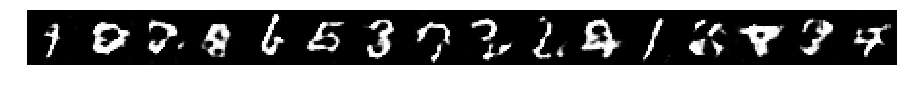

Epochs: 1.07 global_step: 1000 loss_D: 1.203 loss_G: 0.754 duration: 0.777


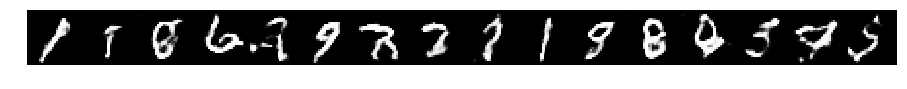

Epochs: 1.60 global_step: 1500 loss_D: 1.171 loss_G: 1.335 duration: 0.780


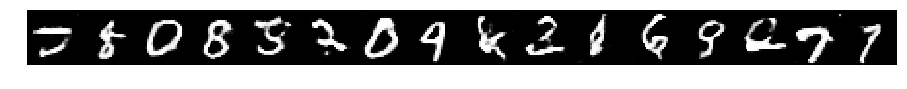

Epochs: 2.13 global_step: 2000 loss_D: 1.009 loss_G: 1.041 duration: 1.006


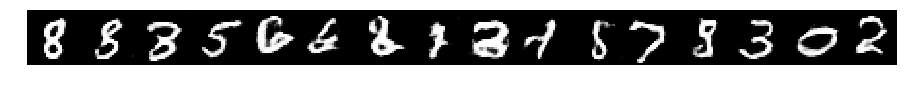

Epochs: 2.67 global_step: 2500 loss_D: 1.090 loss_G: 0.827 duration: 0.928


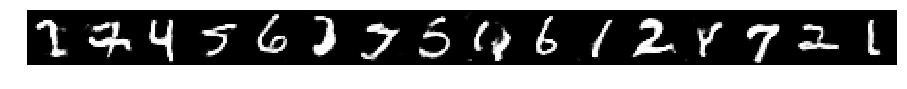

Epochs: 3.20 global_step: 3000 loss_D: 1.010 loss_G: 1.042 duration: 0.871


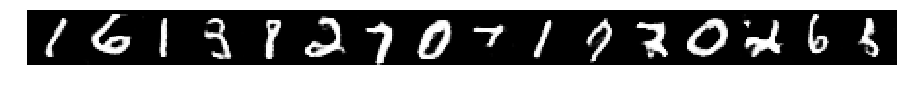

Epochs: 3.73 global_step: 3500 loss_D: 1.013 loss_G: 1.037 duration: 1.295


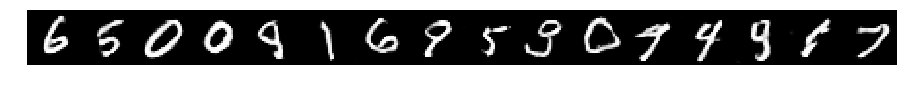

Epochs: 4.27 global_step: 4000 loss_D: 1.119 loss_G: 0.630 duration: 0.869


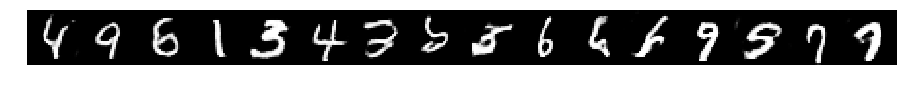

Epochs: 4.80 global_step: 4500 loss_D: 1.181 loss_G: 0.844 duration: 1.008


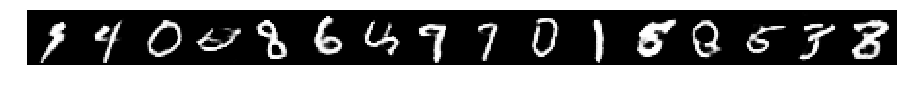

Epochs: 5.33 global_step: 5000 loss_D: 1.089 loss_G: 0.617 duration: 0.765


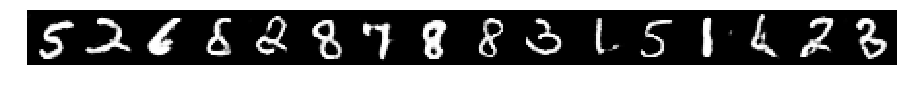

Epochs: 5.87 global_step: 5500 loss_D: 1.084 loss_G: 1.371 duration: 0.980


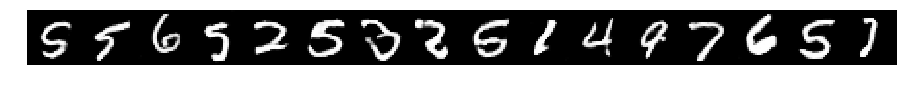

Epochs: 6.40 global_step: 6000 loss_D: 0.978 loss_G: 0.959 duration: 0.872


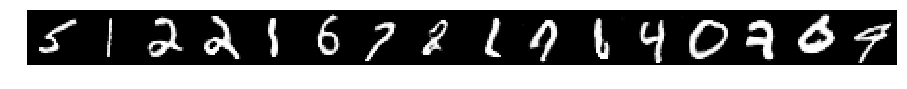

Epochs: 6.93 global_step: 6500 loss_D: 1.074 loss_G: 1.031 duration: 0.962


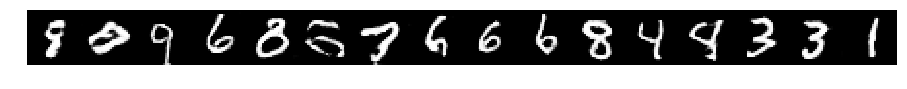

Epochs: 7.47 global_step: 7000 loss_D: 0.997 loss_G: 1.033 duration: 1.139


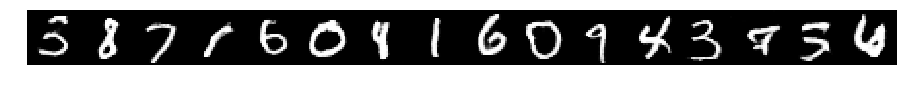

Epochs: 8.00 global_step: 7500 loss_D: 1.133 loss_G: 0.518 duration: 0.839


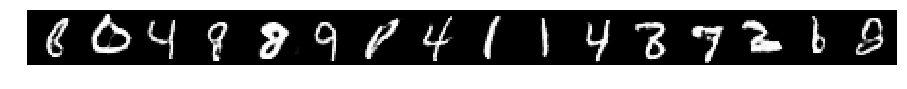

Epochs: 8.53 global_step: 8000 loss_D: 1.046 loss_G: 1.522 duration: 1.153


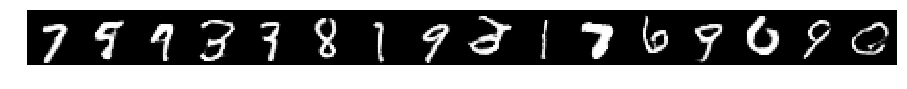

Epochs: 9.07 global_step: 8500 loss_D: 1.039 loss_G: 1.693 duration: 0.977


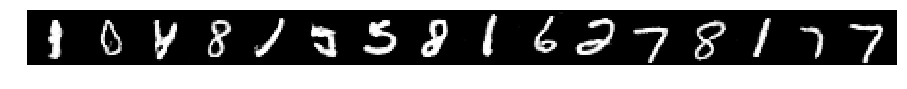

Epochs: 9.60 global_step: 9000 loss_D: 0.999 loss_G: 0.778 duration: 0.765


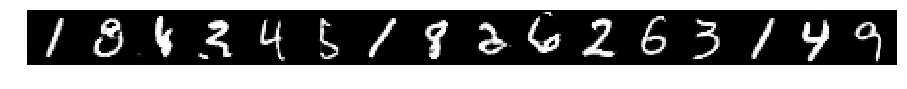

End of dataset
INFO:tensorflow:Saving model with global step 9371 (= 9 epochs) to disk.
INFO:tensorflow:complete training...


In [13]:
sess_configsess_con  = tf.ConfigProto()

global_step_ = 0
start_time = time.time()

with tf.Session(config=sess_config) as sess:
    sess.run(tf.global_variables_initializer())
    tf.logging.info('Start Session.')

    num_examples = len(train_data)
    num_batches_per_epoch = int(num_examples / batch_size)

    # save loss values for plot
    loss_history = []
    pre_epochs = 0
    while True:
        try:
#             start_time = time.time()

            for _ in range(k):
                _, loss_D = sess.run([opt_D_op, model.loss_Discriminator])
            _, global_step_, loss_G = sess.run([opt_G_op,
                                              model.global_step,
                                              model.loss_Generator])

            epochs = global_step_ * batch_size / float(num_examples)

            if global_step_ % print_steps == 0:
                duration = time.time() - start_time
                print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} duration: {:.3f}".format(
                          epochs, global_step_, loss_D, loss_G, duration))

                loss_history.append([epochs, loss_D, loss_G])

                # print sample data
                sample_data = sess.run(model.sample_data)
                print_sample_data(sample_data)
                start_time = time.time()

            # write summaries periodically
            if global_step_ % summary_steps == 0:
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str, global_step=global_step_)

            # save model checkpoint periodically
            if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
                tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
                saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
                pre_epochs = int(epochs)

        except tf.errors.OutOfRangeError:
            print("End of dataset")  # ==> "End of dataset"
            tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
            saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
            break

    tf.logging.info('complete training...')

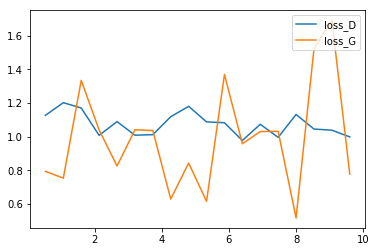

In [14]:
loss_history = np.asarray(loss_history)

plt.plot(loss_history[:,0], loss_history[:,1], label='loss_D')
plt.plot(loss_history[:,0], loss_history[:,2], label='loss_G')
plt.legend(loc='upper right')
plt.show()